# Neural Network 

## 1. Imports

In [1]:
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

## 2. Fetching and preparing data

In [2]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

In [3]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1200, items=100, dropNAPrices=True)

In [4]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
df = hf.rollingMeanDemandFeature(df, windowSize=365, shift=1) 

df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=365, shift=1)

In [5]:
df = hf.rollingMeanWeekday(df, weeks = 4, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 8, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 52, shift = 1) #mean of previous 3 weeks (for that particular weekday)

In [6]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before
df = hf.lagFeature(df, var='sold', lag=365) #Amount sold 28 days before

In [7]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [8]:
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [9]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_28_1','sold_lag_1',
                'sold_lag_7','sold_lag_28']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [10]:
df.shape

(49215, 54)

In [11]:
df = df.astype(float)

In [12]:
#Isolate features and target variable
y = df.sold.values
df = df.drop(['sold'], axis=1)


In [165]:

remove = True
while remove == True:
    mod = sm.OLS(y, df)
    res = mod.fit()
    pval = pd.DataFrame(res.pvalues)
    if len(pval.loc[pval[0] > 0.05]) == 0:
        remove = False
    else:
        worst_col = pval.loc[pval[0] > 0.05].T.columns[pval.loc[pval[0] > 0.05][0].argmax()]
        print(worst_col , pval.loc[pval[0] > 0.05].max()[0])
        df = df.drop([worst_col], axis = 1)
        
    

wday 0.9777677099116514
CA_3 0.9573446009709612
CA_2 0.9394219393520643
TX_3 0.8325592710378074
monfri 0.8169050743118118
WI_3 0.7515639364558877
HOBBIES_1 0.7679300950191361
TX_1 0.6508645760702109
WI 0.653714257245702
FOODS_1 0.7347688367598064
FOODS 0.7435703970628265
month 0.6250394935024901
TX 0.6125292420412276
sell_price 0.531339521208615
HOUSEHOLD_1 0.5338317774729846
HOUSEHOLD_2 0.8659608202114488
HOBBIES_2 0.5004470794392453
WI_1 0.5194275322586709
WI_2 0.5367229831249387
TX_2 0.5735769424998796
CA 0.5648037887910904
National 0.5545321090563089
Sporting 0.4584843014885448
HOBBIES 0.3171456464182742
HOUSEHOLD 0.6500084989390967
FOODS_3 0.40567389679988186
FOODS_2 0.5250221278654446
rolling_mean_52_1 0.21866364636808913
CA_1 0.19891516914382587
CA_4 0.19467535642910533
d 0.1424166503513111
year 0.5484739584451056
snap_WI 0.088522724830024


In [166]:
df.shape

(49215, 20)

In [167]:
df.head()

,snap_CA,snap_TX,Cultural,Religious,NoEvent,Christmas,weekend,midweek,rolling_mean_7_1,rolling_mean_28_1,rolling_mean_365_1,rolling_std_7_1,rolling_std_28_1,rolling_std_365_1,rolling_mean_4_1,rolling_mean_8_1,sold_lag_1,sold_lag_7,sold_lag_28,sold_lag_365
36520,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.004785,0.006780,0.312329,0.487950,0.534522,0.579870,0.25,0.250,0.000000,0.000000,0.000000,0.0
36521,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.002392,0.004237,0.090411,0.377964,0.390021,0.296576,0.00,0.125,0.013514,0.000000,0.000000,0.0
36522,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.023923,0.050847,0.934247,1.511858,2.120697,1.549922,1.25,0.625,0.000000,0.027027,0.000000,0.0
36524,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.035885,0.077966,1.457534,1.772811,2.323107,2.266934,3.50,4.375,0.081081,0.027027,0.013514,2.0
36554,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.007177,0.011017,0.449315,0.786796,0.881167,0.997679,0.75,1.625,0.000000,0.000000,0.000000,0.0


In [168]:
X = df.values

## 3. Setting up loaders

In [169]:
X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [170]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [171]:
X_train.shape, y_train.shape

(torch.Size([39372, 20]), torch.Size([39372]))

In [172]:
# create data loaders

from torch.utils import data

traindataset = data.TensorDataset(X_train, y_train) # create your datset
trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


testdataset = data.TensorDataset(X_test,y_test) # create your datset
testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader



## 4. Building neural net

In [173]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        
        return out

In [174]:
from torchbearer import Trial
import torchbearer

In [175]:
# build the model 
model = BaselineModel(X_train.shape[1], 512)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

loss_plot = []
loss_eval = []
# the epoch loop
for epoch in range(20):
    running_loss = 0.0

    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    loss_plot.append(running_loss/len(trainloader))
    
    model.eval()
    mse = 0
    for index, i in enumerate(testloader):

        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        mse += mean_squared_error(labels, outputs)
    loss_eval.append(mse/len(testloader))
    
    
    print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
print('**** Finished Training ****')



# model = BaselineModel(X_train.shape[1], 256)

# # define the loss function and the optimiser
# loss_function = nn.MSELoss()
# optimiser = optim.Adam(model.parameters()) 

# trial = Trial(model, optimiser, loss_function, metrics=['loss','accuracy'])
# trial.with_generators(trainloader, test_generator=testloader)
# history = trial.run(epochs=20)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print()
# print(results)

Epoch 0, loss 8.55, test loss 5.70
Epoch 1, loss 5.36, test loss 5.93
Epoch 2, loss 5.47, test loss 5.45
Epoch 3, loss 5.34, test loss 5.47
Epoch 4, loss 5.27, test loss 5.53
Epoch 5, loss 5.26, test loss 5.39
Epoch 6, loss 5.26, test loss 5.26
Epoch 7, loss 5.13, test loss 5.79
Epoch 8, loss 5.09, test loss 5.29
Epoch 9, loss 5.07, test loss 5.24
Epoch 10, loss 5.10, test loss 5.37
Epoch 11, loss 5.06, test loss 5.34
Epoch 12, loss 4.96, test loss 5.36
Epoch 13, loss 4.91, test loss 5.07
Epoch 14, loss 5.23, test loss 5.72
Epoch 15, loss 5.41, test loss 5.09
Epoch 16, loss 5.29, test loss 5.14
Epoch 17, loss 4.86, test loss 5.03
Epoch 18, loss 4.85, test loss 5.51
Epoch 19, loss 4.82, test loss 5.12
**** Finished Training ****


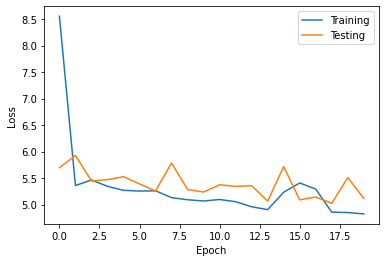

In [176]:
plt.plot(loss_plot, label = "Training")
plt.plot(loss_eval, label = "Testing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [177]:
from sklearn.metrics import mean_squared_error

In [178]:
import matplotlib.pyplot as plt

[[0.4434871 ]
 [0.75426257]
 [0.28697133]
 ...
 [0.04073457]
 [3.3072112 ]
 [0.52095056]]


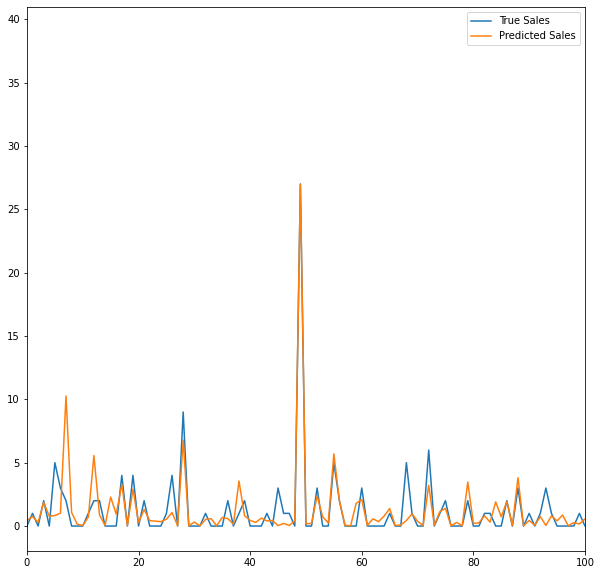

In [179]:
model.eval()
plt.figure(figsize = (10,10))
for index, i in enumerate(trainloader):
    if index < 1:
        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
        print(outputs)
        plt.plot(outputs, label = "Predicted Sales")
        plt.legend()
#         plt.ylim(0, 30)
        plt.xlim(0, 100)
        #print(inputs, labels)
    else:
        break

[[0.0568124 ]
 [3.1181846 ]
 [0.60950345]
 ...
 [1.4082773 ]
 [0.01374622]
 [0.89429915]]


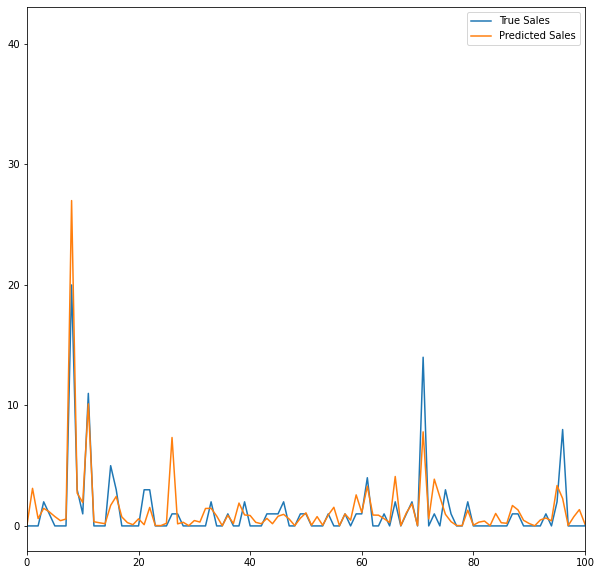

In [180]:
model.eval()
plt.figure(figsize = (10,10))
for index, i in enumerate(testloader):
    if index < 1:
        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
        print(outputs)
        plt.plot(outputs, label = "Predicted Sales")
        plt.legend()
#         plt.ylim(0, 30)
        plt.xlim(0, 100)
        #print(inputs, labels)
    else:
        break

In [181]:
model.eval()

mse = 0

for data in trainloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Train: ", mse/len(trainloader))

Train:  4.778002867331872


In [182]:
model.eval()

mse = 0

for data in testloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Test: ", mse/len(testloader))

Test:  4.942833352088928


In [183]:
def train_model(X_train, y_train, X_test, y_test):
        
        # create data loaders

    from torch.utils import data
    traindataset = data.TensorDataset(X_train, y_train) # create your datset
    trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


    testdataset = data.TensorDataset(X_test,y_test) # create your datset
    testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader


        
        
    # build the model 
    model = BaselineModel(X_train.shape[1], 512)

    # define the loss function and the optimiser
    loss_function = nn.MSELoss()
    optimiser = optim.Adam(model.parameters())

    loss_plot = []
    loss_eval = []
    # the epoch loop
    for epoch in range(20):
        running_loss = 0.0

        for data in trainloader:
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            # keep track of the loss this epoch
            running_loss += loss.item()
        loss_plot.append(running_loss/len(trainloader))

        model.eval()
        mse = 0
        for index, i in enumerate(testloader):

            inputs, labels = i

            outputs = model(inputs)
            outputs = outputs.detach().numpy()
            mse += mean_squared_error(labels, outputs)
        loss_eval.append(mse/len(testloader))


        print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
    print('**** Finished Training ****')

    return(loss_plot[-1], loss_eval[-1])



In [184]:
from sklearn.model_selection import KFold
from torch.utils import data
kf5 = KFold(n_splits=6, shuffle=False)
def kfold_val(X, Y):
    res= []

    for index, (train_index, test_index) in enumerate(kf5.split(range(len(X)))):
        if index < 5:
            res.append(train_model(X[train_index], Y[train_index],X[train_index], Y[train_index]))

    return(np.array(res))

In [185]:
res = kfold_val(X, y)

Epoch 0, loss 6.14, test loss 5.17
Epoch 1, loss 5.07, test loss 5.66
Epoch 2, loss 5.31, test loss 6.30
Epoch 3, loss 5.33, test loss 5.89
Epoch 4, loss 4.82, test loss 4.59
Epoch 5, loss 4.68, test loss 4.73
Epoch 6, loss 4.73, test loss 4.71
Epoch 7, loss 4.76, test loss 4.52
Epoch 8, loss 4.59, test loss 4.40
Epoch 9, loss 4.50, test loss 4.37
Epoch 10, loss 4.60, test loss 4.72
Epoch 11, loss 4.66, test loss 4.35
Epoch 12, loss 4.39, test loss 4.29
Epoch 13, loss 4.39, test loss 5.02
Epoch 14, loss 4.47, test loss 5.74
Epoch 15, loss 4.77, test loss 4.30
Epoch 16, loss 4.60, test loss 5.04
Epoch 17, loss 4.41, test loss 4.30
Epoch 18, loss 4.56, test loss 4.55
Epoch 19, loss 4.60, test loss 4.12
**** Finished Training ****
Epoch 0, loss 7.43, test loss 6.46
Epoch 1, loss 5.91, test loss 5.41
Epoch 2, loss 5.46, test loss 5.30
Epoch 3, loss 5.39, test loss 5.34
Epoch 4, loss 5.31, test loss 5.59
Epoch 5, loss 5.49, test loss 5.54
Epoch 6, loss 5.39, test loss 5.25
Epoch 7, loss 5.1

In [186]:
res

array([[4.59750191, 4.12345966],
       [4.80111242, 4.99739407],
       [5.08901268, 4.74534608],
       [4.74716404, 5.06700064],
       [4.80863765, 5.02899857]])

In [187]:
res = np.asarray(res)

In [188]:
np.mean(res[:, 0]), np.std(res[:, 0])

(4.808685738284413, 0.15938888232756795)

In [189]:
np.mean(res[:, 1]), np.std(res[:, 1])

(4.792439802681528, 0.3530162026172287)